# Revisiting Augmented Lagrangian for Bayesian Optimization

## Abstract

We describe an algorithm for blackbox optimization with blackbox constraints based on a response surface modeling with gaussian processes and Augmented Lagrangian optimization framework. An approach based on this combination was original described by Gramacy et al 2016. Our principal modification to their approach is to move updates of lagrangian multipliers to the inner loop of the algorithm and to reinitialize and estimate multipliers from scratch after every blackbox evaluation. We use EI acquisition over Augmented Lagrangian to obtain the next proposal point for blackbox evaluation. This stratagy proves effective and we achieve state of the art results in terms of number of blackbox evaluations on sythetic benchmarks and real world problems. Our algorithm is implemented in BoTorch - a recent open source library for scalable Monte-Carlo based acquisiton functions.

## Introduction

Bayesian optimization for costly blackbox objectives with costly blackbox constraints is an active research field. There are a number of approaches reported in recent years [Gardner2014,  Hernandez-Lobato2015, Gramacy2016 and Picheny2016, Ariafar2019]. ...



## Algorithm  

We consider optimization problems in canonical form
$$
\begin{eqnarray}
f(x) \rightarrow min.\\
c_i(x) \leq 0, \\
x \in B
\end{eqnarray}
$$

Following Gramacy et. al we model blackbox objective and blackbox constraints with independent GPs and tackle constrained optimization by converting original problem to a series of unconstrained problems using Augmented Lagranigan. Unlike Gramacy et al we choose a classical form of Augmented Lagrangian penalty function  [Rockafellar1973] (_and probably explore other variations of Augmented Lagrangian penalty functions [Iusem1999]_)

$$
L_A(x, \lambda, \rho) = f(x) + \sum_i \phi_{\lambda_i, \rho}(c_i(x))
$$

where classical penalty function is given by 
$$
\phi(t, \lambda, \rho) = \left\{
\begin{eqnarray}
\lambda t + \frac{\rho}{2} t^2, \quad \mathrm{if} \quad \lambda + \rho t \geq 0  \\
-\lambda^2 / (2\rho)  \quad \mathrm{otherwise}
\end{eqnarray}
\right.
$$

This particular form of penalty function is derived from considering a proximal point method for a dual problem ([Rockafellar1973], [Iusem1999], [Nocedal2006, ch. 17]. Consider an ordinary Lagrangian 

$$
L(x, \lambda) = f(x) + \sum_i \lambda_i c_i(x)
$$

Maximizing over $\lambda > 0$ we arrive at the unconstrained optimization problem, which is equivalent to the original constrained problem, but encodes feasibility into function value

$$
F(x) = \max_{\lambda \geq 0} L(x, \lambda) = \left\{
\begin{eqnarray}
f(x) \quad \mathrm{if} \quad x \quad \mathrm{feasible} \\
+\infty \quad \mathrm{otherwise}
\end{eqnarray}
\right.
$$

While this problem is unconstrained it is much harder to optimize, because the objective is discontinious at the border of the feasible region. To arrive at Augmented Lagrangian a regularization term is introduced into the dual problem, requiring that a solution of dual optimization problem is close to some previous estimate $\lambda_i^k$.

$$
F(x) = \max_{\lambda \geq 0} f(x) + \sum_i \lambda_i c_i(x) - \frac{1}{2\rho} \sum_i(\lambda_i - \lambda_i^k) 
$$

This is a separable quadratic optimization problem with bound constraints. From first order optimality condition with respect to $\lambda_i$ we find that

$$
\lambda_i = \max(0, \lambda_i^k + \rho c_i(x))
$$

Substituing this back into the optimization problem we arrive at the form of penalty function for Augmented Lagrangian shown above.

In a Augmented Lagrangian optimization scheme we first solve an unconstrained minimization problem for the Augmented Lagrangian with some fixed lagrange multipliers $\lambda^k$ to find minimizer $x_k$ and then use a dual solution to update estimates of Lagrange multipliers

$$
\lambda_i^{k+1} = \max(0, \lambda_i^k + \rho c_i(x_k)).
$$

This iterative scheme converges to a global optimum for convex objective and convex constraints and it has been shown that convergence is achieved with mild assumptions on the precision of the solutions of intermediate optimization problems [Rockafellar1973, Iusem1999].

Gramacy et al proposed to combine Augmented Lagrangian iterations with the typical Bayesian Optimization approach. Taking an initial set of points they evaluate blackbox objective and constraints and fit independent GP models to them. Next they combine the GPs by an Augmented Lagrangian (with slightly different form than what we use here) and propose to choose next point for evaluation of blackbox objective and constraints by optimizing Expected Improvement (EI) acquisition function over the Augmented Lagrangian. An explicit functional form for EI of Augmented Lagrangian is not known, but it's possible to compute EI using Monte-Carlo. Optimization of EI (inner optimization loop in their algorithm) gives a next proposal point and they proceed by evaluating blackbox objective and constraints at that point. Next they update GPs and update estimates of Lagrange Multipliers using the described update rule. 

Our principal departure from Gramacy et al is to move estimation of the Lagrange Multipliers into the inner loop of the optimization scheme. We note, that after some initial exploration, the GPs provide enough information for a meaningful estimation of Lagrange Multipliers in the inner loop of optimization. We also note, that for non-convex objectives and constraints Lagrange Multipliers are local to each local optimum and it doesn't make much sense to use "global" Lagrange Multipliers. Thus we propose a following modification of the algorithm.

Given the GPs for the objectives and constraints we propose to mimic an Augmented Lagrangian iterations by first optimizing a predictive mean of the Augmented Lagrangian using initial estimates of Lagrange multipliers $\lambda_i^k$ obtaining a point $x_k$ and then update multipliers using expected value of the update rule with respect to GP posterior distribution of $c_i(x)$ at the point $x_k$

$$
\lambda_i^{k+1} = E_{c_i(x)}\left[max(0, \lambda_i^k + \rho c_i(x)\right]
$$

We propose to start the iterations from $\lambda_i^0 = 0$ thus obtaining an estimate of unconstrained maximum at the start of the iterations and than following a path to a border of feasibility region in the course of Augmented Lagrangian iteratoins. In practice we observe quick convergence of the iterations to an equalibrium balancing the estimated value of the objective and the penalty introduced by the non-linear penalty functions.

Our next step is to use the estimated values of Lagrangian multipliers in the optimization of the EI acquisition function over the Augmented Lagrangian, similar to Gramacy et al. The EI acquisition function requires to specify a baseline value over which the improvement is to be found. We propose to use the mean value of Augmented Lagrangian at the final point $x$ of the Augmented Lagrangian iterations (_need some justification for this_). Finally we optimize the EI and obtain the next proposal point. The algorithm is summarised in the Algorithm 1.

Algorithm 1:
1) Initialization:
- choose learning rate $\rho$
- choose uniformly at random M points and evaluate blackbox objective and contraints
- fit GPs for objective and constraints

2) Loop until termination:

2.1) Inner Augmented Lagrangian optimization
- initialize $\lambda_i^0 = 0$
- loop until convergence to point ($x*, \lambda^*$):
  - optimize predictive mean of Augmented Lagrangian to obtain iterate $x_k$
  - update multipliers $\lambda_i^{k+1} = E_{c_i(x)}\left[max(0, \lambda_i^k + \rho c_i(x)\right]$

2.2) Inner Expected Improvement optimization
- compute $L_A^*$ as mean of Augmented Lagrangian at the point $x^*$
- optimize EI of the Augmented Lagrangian using ($\lambda^*, L_A^*$) and obtain proposal point $x$

2.3) Outer loop
- evaluate blackbox objective and constraints at $x$
- update GPs with using the outcome of blackbox functions


## Experiments with synthetic functions

Recently Ariafar et al [Ariafar2019] proposed ADMMBO a Bayesian Optimization scheme combining Alternating Directions Method of Multipliers with GP surrogates and obtained state of the art results for the comprehensive set of synthetic benchmarks. They also provide results of four other methods (_list of methods_) for comparison. We evaluate our method on the same set of synthetic benchmarks and find that results compare favorably to other methods including ADMMBO itself on the basis of total number of blackbox evaluations and on the precision of the solutions

### Test with small feasibility region 
Our result `experiments/classic_gardner_1/results/plots_gardner.ipynb`

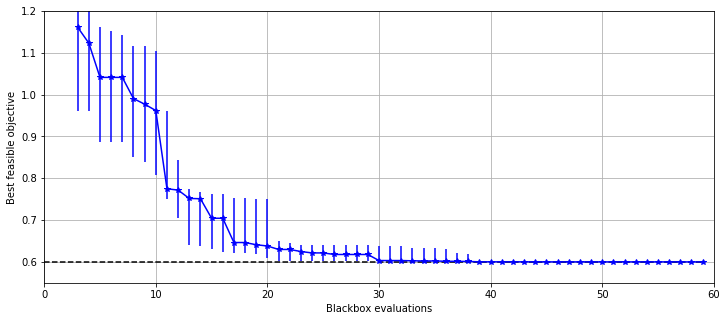

Compare to [Ariafar2019, Section 5.3, Figure 1] 

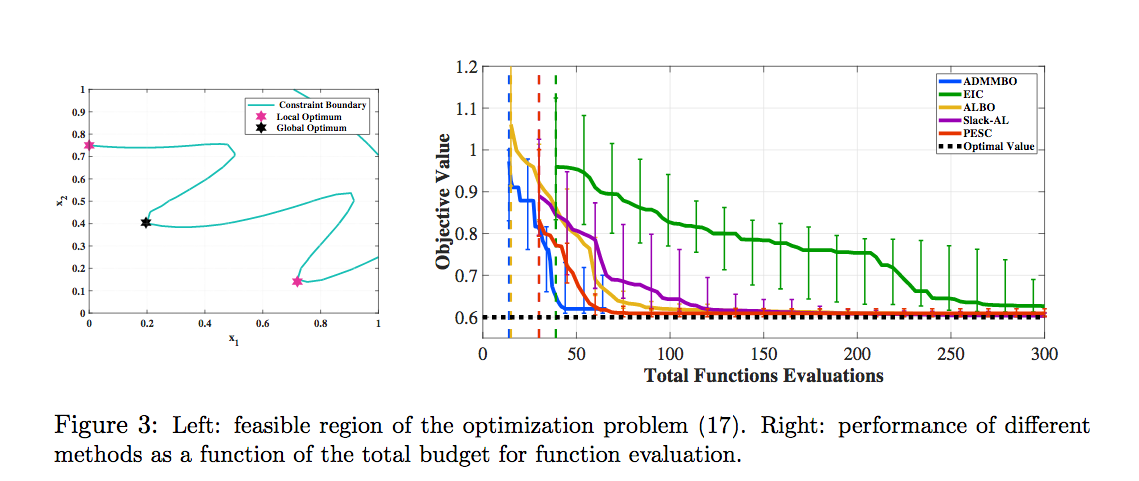


### Test with multiple constraints
Our result `experiments/classic_gramacy_1/results/plots_gramacy.ipynb`

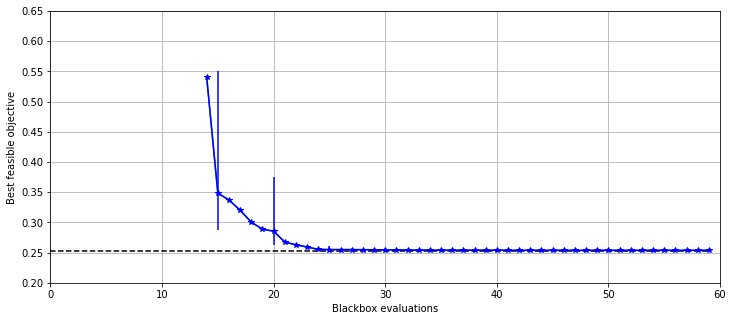

Compare to [Ariafar2019, Section 5.4, Figure 3] 

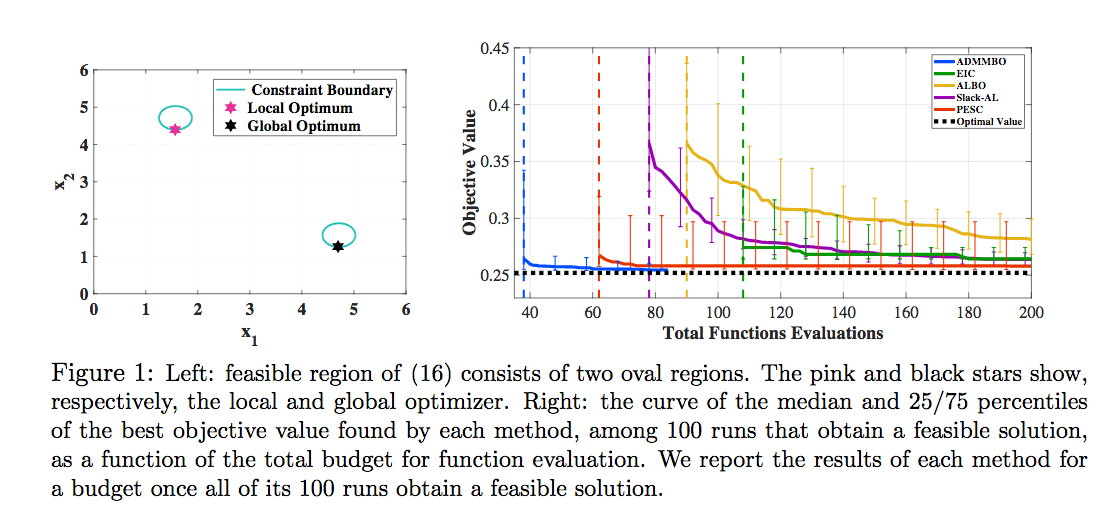

### Test problem in higher dimensions 
TODO



## Experiment on the real-world problem
TODO


## References

[Gramacy2016] https://arxiv.org/abs/1403.4890

[Ariafar2019] http://jmlr.org/papers/volume20/18-227/18-227.pdf
